# Setup

In [ ]:
! pip install -q flax optax einops

     |████████████████████████████████| 180 kB 5.1 MB/s 
     |████████████████████████████████| 145 kB 64.0 MB/s 
     |████████████████████████████████| 217 kB 77.9 MB/s 
     |████████████████████████████████| 51 kB 5.5 MB/s 
     |████████████████████████████████| 85 kB 4.2 MB/s 


In [ ]:
import math
import numpy as np
import jax
from jax import random, jit, grad, jacfwd, jacrev, hessian
import jax.numpy as jnp
from jax.nn.initializers import variance_scaling, normal, orthogonal, delta_orthogonal
from jax.numpy.linalg import norm

import flax.linen as nn
from flax.training import train_state
from functools import partial
import optax
from optax._src.loss import l2_loss

import tensorflow_datasets as tfds

import einops
import matplotlib.pyplot as plt
from typing import Sequence

In [ ]:
class MLP(nn.Module):
  features: Sequence[int]
  stdw: float
  stdb: float
  act_name: str
  def setup(self):
    self.kernel_init = variance_scaling(self.stdw, 'fan_in', 'normal')
    self.bias_init = normal(self.stdb)
    self.layers = [nn.Dense(feat, name=f'layers_{i}', 
                            kernel_init=self.kernel_init, 
                            bias_init=self.bias_init) for i, feat in enumerate(self.features)]
    if self.act_name == 'tanh':
      self.act = nn.tanh 
    elif self.act_name == 'relu':
      self.act = nn.relu
    elif self.act_name == 'gelu':
      self.act = nn.relu
    else:
      raise NameError('Use only tanh, relu or gelu')

  def __call__(self, inputs):
    x = inputs.reshape(inputs.shape[0], -1)
    for i, layer in enumerate(self.layers):
      x = layer(x)
      if i != len(self.features) - 1:
        x = self.act(x)
      # self.sow('inter', 'W', layer.param['kernel'])
    return x


class ResMLP(nn.Module):
  features: Sequence[int]
  stdw: float
  stdb: float
  mu: float
  act_name: str
  def setup(self):
    self.kernel_init = variance_scaling(self.stdw, 'fan_in', 'normal')
    self.bias_init = normal(self.stdb)
    self.layers = [nn.Dense(feat, name=f'layers_{i}', 
                            kernel_init=self.kernel_init, 
                            bias_init=self.bias_init) for i, feat in enumerate(self.features)]
    if self.act_name == 'tanh':
      self.act = nn.tanh 
    elif self.act_name == 'relu':
      self.act = nn.relu
    elif self.act_name == 'gelu':
      self.act = nn.relu
    else:
      raise NameError('Use only tanh, relu or gelu')
    self.norm = nn.LayerNorm()
  def __call__(self, inputs):
    x = inputs.reshape(inputs.shape[0], -1)
    for i, layer in enumerate(self.layers):
      # y = x
      x = layer(x)
      if i != len(self.features) - 1:
        x = self.norm(x)
        x = self.act(x)
        # x = x + self.mu * y
      # self.sow('inter', 'W', layer.param['kernel'])
    return x

In [ ]:
class BI_MLP(nn.Module):
  features_pre: Sequence[int]
  features_post: Sequence[int]
  stdw: float
  stdb: float
  act_name: str
  def setup(self):
    if self.act_name == 'tanh': 
      self.act = nn.tanh
    elif self.act_name == 'relu': 
      self.act = nn.relu
    elif self.act_name == 'gelu':
      self.act = nn.gelu
    else:
      raise NameError('Use only tanh, relu or gelu')

    self.pre_feature = MLP(self.features_pre, self.stdw, self.stdb, self.act_name)
    self.post_feature = nn.Sequential([self.act, 
                                      MLP(self.features_post, self.stdw, self.stdb, self.act_name)])

  def __call__(self, inputs):
    x = self.pre_feature(inputs)
    x = self.post_feature(x)
    return x

In [ ]:
class MlpBlock(nn.Module): 
  mlp_dim: int
  stdw: float
  stdb: float

  def setup(self):
    kernel_inti = variance_scaling(self.stdw, 'fan_in', 'normal')
    bias_inti = normal(self.stdb)

  @nn.compact
  def __call__(self, x):
    y = nn.Dense(self.mlp_dim, kernel_init=self.kernel_init, bias_init=self.bias_init)(x)
    y = nn.gelu(y)
    return nn.Dense(x.shape[-1])(y)


class MixerBlock(nn.Module): 
  tokens_mlp_dim: int 
  channels_mlp_dim: int 
  stdw: float
  stdb: float

  @nn.compact
  def __call__(self, x):
    y = nn.LayerNorm()(x) 
    y = jnp.swapaxes(y, 1, 2) 
    y = MlpBlock(self.tokens_mlp_dim, self.stdw, self.stdb, name='token_mixing')(y) 
    y = jnp.swapaxes(y, 1, 2)
    x = x + y
    y = nn.LayerNorm()(x)
    return x + MlpBlock(self.channels_mlp_dim, self.stdw, self.stdb, name='channel_mixing')(y)


class MlpMixer(nn.Module): 
  num_classes: int
  num_blocks: int 
  patch_size: int 
  hidden_dim: int
  tokens_mlp_dim: int
  channels_mlp_dim: int
  stdw: float
  stdb: float

  @nn.compact
  def __call__(self, x):
    s = self.patch_size
    x = nn.Conv(self.hidden_dim, (s,s), strides=(s,s), name='stem')(x)
    x = einops.rearrange(x, 'n h w c -> n (h w) c') 
    for _ in range(self.num_blocks):
      x = MixerBlock(self.tokens_mlp_dim, self.channels_mlp_dim, self.stdw, self.stdb)(x) 
    x = nn.LayerNorm(name='pre_head_layer_norm')(x)
    x = jnp.mean(x, axis=1)
    return nn.Dense(self.num_classes, name='head', kernel_init=nn.initializers.zeros)(x)

In [ ]:
def cse(*, logits, labels):
  labels_onehot = jax.nn.one_hot(labels, num_classes=10)
  return optax.softmax_cross_entropy(logits, labels_onehot).mean()


def mse(*, logits, labels):
  labels_onehot = jax.nn.one_hot(labels, num_classes=10)
  return 0.5 * ((logits - labels_onehot)**2).mean()


def compute_metrics(*, logits, labels):
  loss = mse(logits=logits, labels=labels)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  metrics = {
      'loss': loss,
      'accuracy': accuracy,
  }
  return metrics

In [ ]:
@jit
def train_step(state, batch):
  def loss_fn(params):
    # logits = MLP([200, 200, 200, 200, 10], 1.0, 0.0).apply({'params': params}, batch['image'])
    logits = state.apply_fn({'params': params}, batch['image'])
    loss = mse(logits=logits, labels=batch['label']) 
    return loss, logits

  flat_params, rebuild_fn = jax.flatten_util.ravel_pytree(state.params)
  def loss_fn_flat(flat_params):
    unflat_params = rebuild_fn(flat_params)
    loss, _ = loss_fn(unflat_params)
    return loss

  def hvp(flat_params, v):
    return jax.jvp(grad(loss_fn_flat), [flat_params], [v])[1]

  body_hvp = jax.tree_util.Partial(hvp, flat_params)
  #  i here is only for fori_loop usage
  def fori_hvp(i, v):
    return body_hvp(v / norm(v))

  # Power Iteration
  key = random.PRNGKey(42)
  v = jax.random.normal(key, shape=flat_params.shape)
  v = v / norm(v)
  v = jax.lax.fori_loop(0, 20, fori_hvp, v / norm(v))
  top_eig = jnp.vdot(v / norm(v), hvp(flat_params, v / norm(v)))

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (_, logits), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  metrics = compute_metrics(logits=logits, labels=batch['label'])
  metrics['top_eig'] = top_eig
  return state, metrics


@jit
def eval_step(state, batch):
  # logits = MLP([200, 200, 200, 200, 10], 1.0, 0.0).apply({'params': params}, batch['image'])
  logits = state.apply_fn({'params': state.params}, batch['image'])
  return compute_metrics(logits=logits, labels=batch['label'])

In [ ]:
def get_datasets(num_train: int=5000, num_test: int=1000):
  """Load MNIST train and test datasets into memory."""
  split_train = 'train[:' + str(num_train) + ']'
  split_test = 'test[:' + str(num_test) + ']'
  ds_builder = tfds.builder('cifar10')
  ds_builder.download_and_prepare()
  # train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train[:num_train]', batch_size=-1))
  # test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test[:num_test]', batch_size=-1))
  train_ds = tfds.as_numpy(ds_builder.as_dataset(split=split_train, batch_size=-1))
  test_ds = tfds.as_numpy(ds_builder.as_dataset(split=split_test, batch_size=-1))
  train_ds['image'] = jnp.float32(train_ds['image']) / 127.5 - 1.0
  test_ds['image'] = jnp.float32(test_ds['image']) / 127.5 - 1.0
  train_ds.pop('id')
  test_ds.pop('id')
  return train_ds, test_ds


def create_train_state(rng, learning_rate, momentum, weight_decay, features, stdw, stdb, act_name):
  """Creates initial `TrainState`."""
  model = MLP(features, stdw, stdb, act_name)
  params = model.init(rng, jnp.ones([1, 3072]))['params']
  optimizer = optax.chain(optax.sgd(learning_rate, momentum),
                          optax.add_decayed_weights(weight_decay),
                          )
  return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)


def create_train_state_res(rng, learning_rate, momentum, weight_decay, features, stdw, stdb, mu, act_name):
  """Creates initial `TrainState`."""
  model = ResMLP(features, stdw, stdb, mu, act_name)
  params = model.init(rng, jnp.ones([1, 3072]))['params']
  optimizer = optax.chain(optax.sgd(learning_rate, momentum),
                          optax.add_decayed_weights(weight_decay),
                          )
  return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)


def create_train_state_bi(rng, learning_rate, momentum, weight_decay, features1, features2, stdw, stdb, act_name):
  """Creates initial `TrainState`."""
  model = BI_MLP(features1, features2, stdw, stdb, act_name)
  params = model.init(rng, jnp.ones([1, 3072]))['params']
  optimizer = optax.chain(optax.sgd(learning_rate, momentum),
                          optax.add_decayed_weights(weight_decay),
                          )
  return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)


def create_train_state_adamw(rng, learning_rate, b1, b2, eps, weight_decay, features, stdw, stdb, act_name):
  """Creates initial `TrainState`."""
  model = MLP(features, stdw, stdb, act_name)
  params = model.init(rng, jnp.ones([1, 3072]))['params']
  optimizer = optax.adamw(learning_rate, b1=b1, b2=b2, eps=eps, weight_decay=weight_decay)
  return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)


def create_train_state_adamw_bi(rng, learning_rate, b1, b2, eps, weight_decay, features1, features2, stdw, stdb, act_name):
  """Creates initial `TrainState`."""
  model = BI_MLP(features1, features2, stdw, stdb, act_name)
  params = model.init(rng, jnp.ones([1, 3072]))['params']
  optimizer = optax.adamw(learning_rate, b1=b1, b2=b2, eps=eps, weight_decay=weight_decay)
  return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

In [ ]:
def train_epoch(state, train_ds, batch_size, epoch, rng):
  """Train for a single epoch."""
  train_ds_size = len(train_ds['image'])
  steps_per_epoch = train_ds_size // batch_size

  perms = jax.random.permutation(rng, train_ds_size)
  perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
  perms = perms.reshape((steps_per_epoch, batch_size))
  batch_metrics = []
  for perm in perms:
    batch = {k: v[perm, ...] for k, v in train_ds.items()}
    state, metrics = train_step(state, batch)
    batch_metrics.append(metrics)

  # compute mean of metrics across each batch in epoch.
  batch_metrics_np = jax.device_get(batch_metrics)
  epoch_metrics_np = {
      k: np.mean([metrics[k] for metrics in batch_metrics_np])
      for k in batch_metrics_np[0]}

  # print('train epoch: %d, loss: %.4f, accuracy: %.2f' % (
      # epoch, epoch_metrics_np['loss'], epoch_metrics_np['accuracy'] * 100))

  return state, epoch_metrics_np


def eval_model(state, test_ds):
  metrics = eval_step(state, test_ds)
  metrics = jax.device_get(metrics)
  summary = jax.tree_map(lambda x: x.item(), metrics)
  return summary['loss'], summary['accuracy']

# Run

In [ ]:
train_ds, test_ds = get_datasets()
# batch = {k: v[[100], ...] for k, v in train_ds.items()}

In [ ]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)

learning_rate = 2 / 10
weight_decay = 5e-5
b1 = 0.9
b2 = 0.999
eps = 1e-8
momentum = 0.0
features = [200, 200, 10]
features1 = [500, 500]
features2 = [500, 10]
stdw = 1.0
stdb = 0.0
mu = 1.0
act_name = 'relu'
# b1, b2, eps = [0.9, 0.95, 1e-8]
state = create_train_state_res(init_rng, learning_rate, momentum, weight_decay, features, stdw, stdb, mu, act_name)
# state = create_train_state_adamw(init_rng, learning_rate, b1, b2, eps, weight_decay, features, stdw, stdb, act_name)

num_epochs = 5000
batch_size = 5000

del init_rng

In [ ]:
data = {'loss': [], 'tr_acc':[], 'test_acc': [], 'test_loss': [], 'top_eig': [], 'last_weight_norm': []}
for epoch in range(1, num_epochs + 1):
  # Use a separate PRNG key to permute image data during shuffling
  rng, input_rng = jax.random.split(rng)
  # Run an optimization step over a training batch
  state, epoch_metrics = train_epoch(state, train_ds, batch_size, epoch, input_rng)
  # Evaluate on the test set after each training epoch 
  test_loss, test_accuracy = eval_model(state, test_ds)
  
  data['loss'].append(epoch_metrics['loss'])
  data['tr_acc'].append(epoch_metrics['accuracy'])
  data['top_eig'].append(epoch_metrics['top_eig'])
  data['test_acc'].append(test_accuracy)
  data['test_loss'].append(test_loss)
  data['last_weight_norm'].append(jnp.power(state.params['layers_2']['kernel'], 2).mean())
  if epoch % 100 == 0 or epoch == 1:
    print('test epoch: %d, loss: %.2f, accuracy: %.2f, top eig: %.2f' % (
          epoch, data['loss'][-1], test_accuracy * 100, data['top_eig'][-1]))

test epoch: 1, loss: 0.30, accuracy: 9.40, top eig: 35.15
test epoch: 100, loss: 0.04, accuracy: 31.20, top eig: 8.45
test epoch: 200, loss: 0.04, accuracy: 34.30, top eig: 8.29
test epoch: 300, loss: 0.03, accuracy: 35.50, top eig: 8.31
test epoch: 400, loss: 0.03, accuracy: 36.40, top eig: 8.41
test epoch: 500, loss: 0.03, accuracy: 36.10, top eig: 8.56
test epoch: 600, loss: 0.03, accuracy: 37.60, top eig: 8.73
test epoch: 700, loss: 0.03, accuracy: 38.00, top eig: 8.94
test epoch: 800, loss: 0.03, accuracy: 38.60, top eig: 9.15
test epoch: 900, loss: 0.03, accuracy: 37.70, top eig: 9.38
test epoch: 1000, loss: 0.03, accuracy: 36.70, top eig: 9.47
test epoch: 1100, loss: 0.03, accuracy: 35.70, top eig: 9.68
test epoch: 1200, loss: 0.02, accuracy: 37.60, top eig: 9.89
test epoch: 1300, loss: 0.02, accuracy: 36.00, top eig: 10.12
test epoch: 1400, loss: 0.02, accuracy: 35.60, top eig: 9.69
test epoch: 1500, loss: 0.02, accuracy: 37.30, top eig: 9.98
test epoch: 1600, loss: 0.02, accur

Text(0.5, 1.0, '$\\sigma_w=1.0$, tanh')

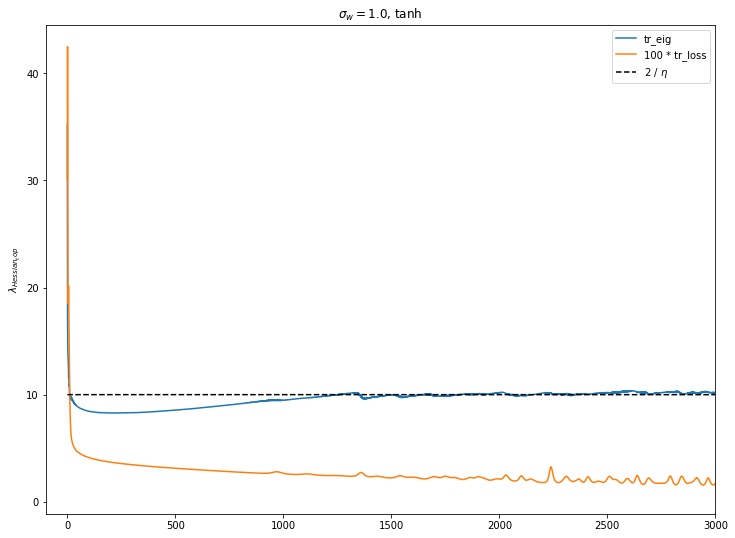

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

ax.plot(data['top_eig'], label='tr_eig')

# ax2 = plt.subplot(312, sharex=ax)
ax.plot(100 * np.array(data['loss']), label='100 * tr_loss')
ax.plot(10 * np.ones_like(data['top_eig']), 'k--', label='2 / $\\eta$')
ax.set_xlim([-100, 3000])
ax.legend()
ax.set_ylabel('$\\lambda_{Hessian_top}$')
ax.set_title('$\\sigma_w=1.0$, tanh')

# Slingshot

In [ ]:
def get_onebatch():
  ds_builder = tfds.builder('cifar10')
  ds_builder.download_and_prepare()
  train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train[:256]', batch_size=-1))
  test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test[:256]', batch_size=-1))
  train_ds['image'] = jnp.float32(train_ds['image']) / 127.5 - 1.0
  test_ds['image'] = jnp.float32(test_ds['image']) / 127.5 - 1.0
  train_ds.pop('id')
  test_ds.pop('id')
  return train_ds, test_ds

In [ ]:
train_ds, test_ds = get_onebatch()
# batch = {k: v[[100], ...] for k, v in train_ds.items()}

In [ ]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)

learning_rate = 1e-3
weight_decay = 0.0
momentum = 0.0
features = [500, 500, 10]
features1 = [500, 500]
features2 = [500, 10]
stdw = math.sqrt(2.0)
stdb = 0.0
act_name = 'relu'
b1, b2, eps = [0.9, 0.95, 1e-8]
# state = create_train_state(init_rng, learning_rate, momentum, weight_decay, features, stdw, stdb, act_name)
state = create_train_state_adamw(init_rng, learning_rate, b1, b2, eps, weight_decay, features, stdw, stdb, act_name)

num_epochs = 2000
batch_size = 256

del init_rng

In [ ]:
data = {'loss': [], 'tr_acc':[], 'test_acc': [], 'test_loss': [], 'top_eig': [], 'last_weight_norm': []}
for epoch in range(1, num_epochs + 1):
  # Use a separate PRNG key to permute image data during shuffling
  rng, input_rng = jax.random.split(rng)
  # Run an optimization step over a training batch
  state, epoch_metrics = train_epoch(state, train_ds, batch_size, epoch, input_rng)
  # Evaluate on the test set after each training epoch 
  test_loss, test_accuracy = eval_model(state, test_ds)
  
  data['loss'].append(epoch_metrics['loss'])
  data['tr_acc'].append(epoch_metrics['accuracy'])
  data['top_eig'].append(epoch_metrics['top_eig'])
  data['test_acc'].append(test_accuracy)
  data['test_loss'].append(test_loss)
  data['last_weight_norm'].append(jnp.power(state.params['layers_2']['kernel'], 2).mean())
  
  print('test epoch: %d, loss: %.2f, accuracy: %.2f, top eig: %.2f' % (
      epoch, data['loss'][-1], test_accuracy * 100, data['top_eig'][-1]))

train epoch: 1, loss: 2.3878, accuracy: 12.11
test epoch: 1, loss: 2.39, accuracy: 19.14, top eig: 14.64
train epoch: 2, loss: 1.7773, accuracy: 39.06
test epoch: 2, loss: 1.78, accuracy: 21.88, top eig: 22.62
train epoch: 3, loss: 1.5442, accuracy: 49.22
test epoch: 3, loss: 1.54, accuracy: 24.61, top eig: 24.16
train epoch: 4, loss: 1.1348, accuracy: 67.97
test epoch: 4, loss: 1.13, accuracy: 27.73, top eig: 25.01
train epoch: 5, loss: 0.9594, accuracy: 76.17
test epoch: 5, loss: 0.96, accuracy: 28.12, top eig: 27.40
train epoch: 6, loss: 0.7399, accuracy: 84.77
test epoch: 6, loss: 0.74, accuracy: 27.34, top eig: 30.05
train epoch: 7, loss: 0.5683, accuracy: 89.45
test epoch: 7, loss: 0.57, accuracy: 25.78, top eig: 30.04
train epoch: 8, loss: 0.4333, accuracy: 93.75
test epoch: 8, loss: 0.43, accuracy: 26.17, top eig: 33.25
train epoch: 9, loss: 0.3439, accuracy: 95.31
test epoch: 9, loss: 0.34, accuracy: 27.34, top eig: 28.72
train epoch: 10, loss: 0.2366, accuracy: 98.44
test epo

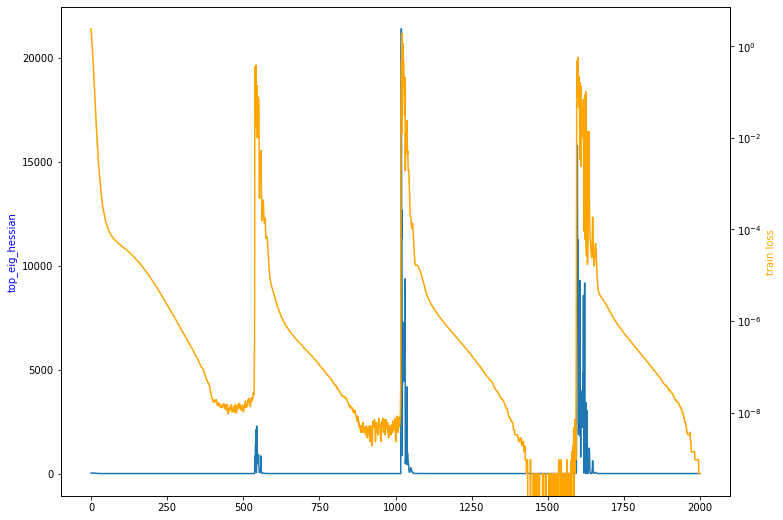

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))
axt = ax.twinx()
ax.plot(data['top_eig'])
ax.set_ylabel('top_eig_hessian')
axt.plot(data['loss'], 'orange')
axt.set_ylabel('train loss')
# ax.spines['left'].set_color('blue')
# axt.spines['right'].set_color('orange')
# ax.set_yscale('log')
ax.yaxis.label.set_color('blue')
axt.yaxis.label.set_color('orange')
axt.set_yscale('log')

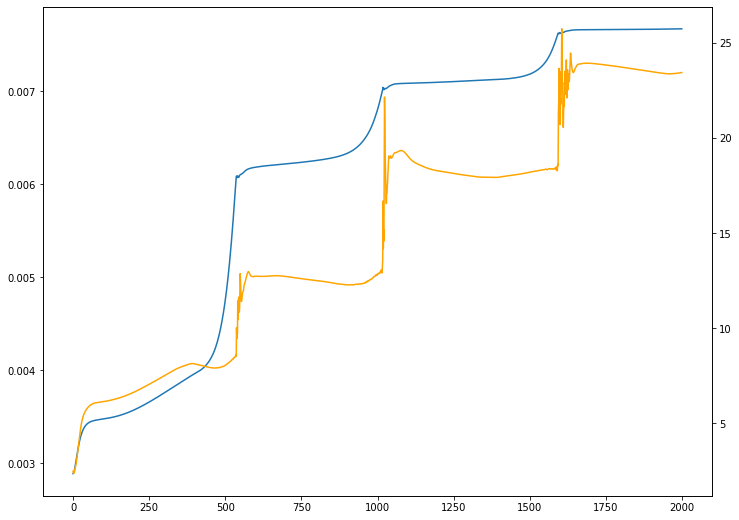

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))
axt = ax.twinx()
# ax.plot(data['test_acc'])
ax.plot(data['last_weight_norm'])
axt.plot(data['test_loss'], 'orange')

# axt.set_yscale('log')